In [1]:
from all_functions import * 
from sklearn.decomposition import PCA
import copy
from scipy.linalg import eigh
from sklearn.linear_model import LinearRegression

In [2]:
"""
This new functions takes the following inputs: 

    name -- the name of the Y variables, should be within double quote
    ncomps -- number of principal components to be used 
    error_comps -- number of error components to be used 
    outlier_remove -- a logical variable indicating whether to remove outliers 
    
This function select the Y variable based on the input name, and set X as 
all other variables. 

"""
def FRED_MD_DATA_PREP(name, ncomps = 5, error_comps = 5, outlier_remove = False):
   
    """
    Read the entire data
    """
    
    data = pd.read_csv('Transformed_na_removed.csv')
    
    """
    Set the Y axis to be the column of given name in the input, 
    remove that column and set the rest of the matrix as X. 
    Finally, do PCA on the X matrix. 
    
    """
    
    Y_axis = name
    X = copy.deepcopy(data)
    X.pop(name)
    X = X.to_numpy()
    n_data = X.shape[0]
    Y = data[name].to_numpy()
    W, V = eigh(X @ X.T)
    F_hat = np.sqrt(n_data) * V[:,-ncomps:] # select last ncomps columns of V
    B_hat = (1/n_data) * (X.T @ F_hat)
    
    if error_comps > 0:
        
        """
        First we project out the space of principal components
        to estimate the idiosyncratic errors. 
        """
        
#         loadings = X.T @ X_pca @ np.linalg.inv(X_pca.T @ X_pca) # OLS of X on X.pca
#         errors = X - X_pca @ loadings.T # OLS residuals
        U_hat = X - (F_hat @ B_hat.T)
        model = LinearRegression()
        model.fit(F_hat, Y)
        Y_u = Y - model.predict(F_hat)
        
        
        """
            Next we apply conditional SURE independent screening to select the 
            idiosyncratic components.
        """
       
        def cor_cal(x):
            return np.corrcoef(x, Y_u)[0, 1]
        
        cor_vec = np.apply_along_axis(cor_cal, 0, U_hat)
        idx = np.argsort(-np.abs(cor_vec))
        errors_to_add = U_hat[:,idx[:error_comps]]
        Data = np.hstack([F_hat, errors_to_add, Y.reshape(-1, 1)])
    
    else:
        Data = np.hstack([F_hat, Y.reshape(-1, 1)])
    
    if outlier_remove:
        Q1 = np.percentile(Y, 25, method = 'midpoint')
        Q3 = np.percentile(Y, 75, method = 'midpoint')
        IQR = Q3 - Q1
        upper=Q3+1.5*IQR
        upper_array=np.array(Y<=upper)
        lower=Q1-1.5*IQR
        lower_array=np.array(Y>=lower)
        index_keep = upper_array & lower_array
        Data = Data[index_keep[:,0].tolist(),:]
        print("The number of data being removed is ", Y.shape[0]-Data.shape[0])
        
    return Data, Y_axis

In [3]:
def UTOPIA_FRED_MD_MULTIVARIATE(Data, shrink = True):
    train_idx = int(Data.shape[0] * 0.8)
    train_data, test_data = np.split(Data, [train_idx])
    X_pre = train_data[:,:-1]
    Y_pre = train_data[:,-1].reshape(-1,1)
    X_opt = train_data[:,:-1]
    Y_opt = train_data[:,-1].reshape(-1,1)
    X_adj = train_data[:,:-1]
    Y_adj = train_data[:,-1].reshape(-1,1)
    X_t = test_data[:,:-1]
    Y_t = test_data[:,-1].reshape(-1,1)


    n_pre = len(Y_pre)
    n_opt = len(Y_opt)
    n_adj = len(Y_adj)
    n_t = len(Y_t)

    # Obtain mean estimator
    known_mean = "False"
    if known_mean == "True":
        M_pre = np.zeros(n_pre).reshape(-1,1)
        M_opt = np.zeros(n_opt).reshape(-1,1)
        M_adj = np.zeros(n_adj).reshape(-1,1)
        M_t = np.zeros(n_t).reshape(-1,1)
    else:
        est_type = "NN1"
        M_pre, M_opt, M_adj, M_t = mean_est(est_type,X_pre,Y_pre,X_opt,X_adj,X_t)

    # Obtain variance estimator
    var_opt, var_adj, var_t = var_est(X_pre,Y_pre,M_pre,X_opt,X_adj,X_t,est_type ="NN1")


    # Obtain quantile estimators
    quantile = [0.05,0.35,0.65,0.95]
    m1,Q1_opt,Q1_adj,Q1_t = est_quantile("NN1",quantile[0],X_pre,Y_pre,X_opt,X_adj,X_t)
    m2,Q2_opt,Q2_adj,Q2_t = est_quantile("NN2",quantile[1],X_pre,Y_pre,X_opt,X_adj,X_t)
    m3,Q3_opt,Q3_adj,Q3_t = est_quantile("qrf",quantile[2],X_pre,Y_pre,X_opt,X_adj,X_t)
    m4,Q4_opt,Q4_adj,Q4_t = est_quantile("gb",quantile[3],X_pre,Y_pre,X_opt,X_adj,X_t)

    # construct estimator matrix
    E_opt = np.hstack(((Q1_opt-M_opt)**2, (Q2_opt-M_opt)**2, (Q3_opt-M_opt)**2, (Q4_opt-M_opt)**2, var_opt))
    E_opt = E_opt.T
    E_adj = np.hstack(((Q1_adj-M_adj)**2, (Q2_adj-M_adj)**2, (Q3_adj-M_adj)**2, (Q4_adj-M_adj)**2, var_adj))
    E_adj = E_adj.T
    E_t = np.hstack(((Q1_t-M_t)**2, (Q2_t-M_t)**2, (Q3_t-M_t)**2, (Q4_t-M_t)**2, var_t))
    E_t = E_t.T


    # solve optimization problem

    optimal_weight, V100_adj, V100_t= solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "aug", E_opt, E_adj, E_t)
    # opt_sol, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_poly", degree = 2)
    # opt_sol, V100_adj, V100_t = solve_opt(X_opt,Y_opt, M_opt, M_adj, M_t, X_adj, X_t, "rkhs_rbf", sigma = 1)

    # adjust interval
    if shrink: 
        alpha = 0.05
        delta = interval_adj(X_adj,Y_adj,M_adj,V100_adj,alpha,stepsize = 0.001)

        # plot
        V_alpha_t = delta*V100_t
    else:
        V_alpha_t = V100_t
    
    coverage = (np.power(Y_t[:,0]-M_t[:,0], 2) <= V_alpha_t[:,0]).mean()
    bandwidth = np.mean(V_alpha_t[:,0])
    print("The overall coverage for UTOPIA is", coverage)
    print("Mean bandwidth on test data for UTOPIA is", bandwidth)
    return X_t,Y_t,M_t,V_alpha_t,coverage,bandwidth

In [4]:
def LQR_FRED_MD_MULTIVARIATE(Data):
    train_idx = int(Data.shape[0] * 0.8)
    train_data, test_data = np.split(Data, [train_idx])

    X_lin = train_data[:,:-1]
    Y_lin = train_data[:,-1].reshape(-1,1)
    y_lin = Y_lin[:,0]
    X_quantile = train_data[:,:-1]
    Y_quantile = train_data[:,-1].reshape(-1,1)
    X_test = test_data[:,:-1]
    Y_test = test_data[:,-1].reshape(-1,1)

    # Estimate the mean using NN1
    est_type = "NN1"
    M_quantile, M_test = mean_est_others(est_type,X_lin,Y_lin,X_quantile,X_test)

    # Estimate the quantile
    alpha = 0.05

    model_quantile = QuantileRegressor(quantile=1-(alpha/2), alpha=0, solver = 'highs')
    model_quantile.fit(X_quantile, (Y_quantile-M_quantile).reshape(-1))
    Q_test = model_quantile.predict(X_test)


    V_test = Q_test**2
    V_test = V_test.reshape(-1,1)
    coverage = (np.power(Y_test[:,0]-M_test[:,0], 2) <= V_test[:,0]).mean()
    bandwidth = np.mean(V_test[:,0])
    print("The overall coverage for LQR is", coverage)
    print("Mean bandwidth on test data for LQR is", bandwidth)
    return X_test,Y_test,M_test,V_test, coverage, bandwidth

In [5]:
def SplitCF_FRED_MD_MULTIVARIATE(Data): 
    train_idx = int(Data.shape[0] * 0.8)
    train_data, test_data = np.split(Data, [train_idx])


    X_lin = train_data[:,:-1]
    Y_lin = train_data[:,1].reshape(-1,1)
    y_lin = Y_lin[:,0]
    X_res = train_data[:,:-1]
    Y_res = train_data[:,1].reshape(-1,1)
    y_res = Y_res[:,0]
    X_test = test_data[:,:-1]
    Y_test = test_data[:,1].reshape(-1,1)
    y_test = Y_test[:,0]

    # Estimate the mean using NN1
    est_type = "NN1"
    Y_res_pred, M_test = mean_est_others(est_type,X_lin,Y_lin,X_res,X_test)
    y_res_pred = Y_res_pred[:,0]

    # Calculate the conformity scores
    residuals = np.abs(y_res - y_res_pred)

    alpha = 0.05  # 95% confidence level
    k = int((1 - alpha) * len(y_lin))
    residuals_sorted = np.sort(residuals)
    threshold = residuals_sorted[k]

    # Calculate the prediction interval
    v_test = (threshold**2)*np.ones(len(y_test))
    V_test = v_test.reshape(-1,1)
    coverage = (np.power(Y_test[:,0]-M_test[:,0], 2) <= V_test[:,0]).mean()
    bandwidth = np.mean(V_test[:,0])
    print("The overall coverage for SplitCF is", coverage)
    print("Mean bandwidth on test data for SplitCF is", bandwidth)
    return X_test,Y_test,M_test,V_test,coverage,bandwidth

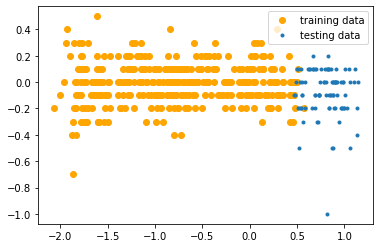

In [6]:
Data, Y_axis = FRED_MD_DATA_PREP('UNRATE')
train_idx = int(Data.shape[0] * 0.8)
train_data, test_data = np.split(Data, [train_idx])
plt.plot(train_data[:,2],train_data[:,-1],'o',color = 'orange',label = 'training data')
plt.plot(test_data[:,2],test_data[:,-1],'.', label = 'testing data')
plt.legend(loc="upper right")
plt.show()

In [7]:

Data, Y_axis = FRED_MD_DATA_PREP('UNRATE', ncomps=2, error_comps=3)


X_t,Y_t,M_t,V_alpha_t,covarage,bandwidth = UTOPIA_FRED_MD_MULTIVARIATE(Data, shrink = True)
X_test,Y_test,M_test,V_test,covarage,bandwidth = LQR_FRED_MD_MULTIVARIATE(Data)
X_test,Y_test,M_test,V_test,coverage,bandwidth = SplitCF_FRED_MD_MULTIVARIATE(Data)


The overall coverage for UTOPIA is 0.945054945054945
Mean bandwidth on test data for UTOPIA is 0.07003996331154592
The overall coverage for LQR is 0.7692307692307693
Mean bandwidth on test data for LQR is 0.019481736196401932
The overall coverage for SplitCF is 0.5824175824175825
Mean bandwidth on test data for SplitCF is 0.00032963343301290485


In [23]:

Data, Y_axis = FRED_MD_DATA_PREP('HOUST', ncomps=2, error_comps=3)


#X_t,Y_t,M_t,V_alpha_t,covarage,bandwidth = UTOPIA_FRED_MD_MULTIVARIATE(Data, shrink = True)
X_test,Y_test,M_test,V_test,covarage,bandwidth = LQR_FRED_MD_MULTIVARIATE(Data)
#X_test,Y_test,M_test,V_test,coverage,bandwidth = SplitCF_FRED_MD_MULTIVARIATE(Data)

The overall coverage for LQR is 0.0
Mean bandwidth on test data for LQR is 2.3525688864854297


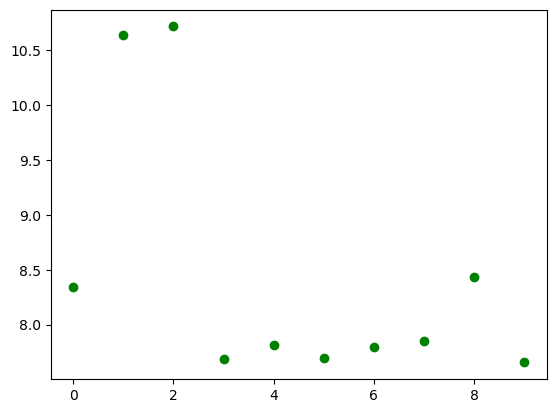

In [28]:
#plt.plot(Y_test[20:30,0], 'o')
#plt.plot(M_test[20:30,0] + np.sqrt(V_test[20:30,0]), 'o', color = 'red')
plt.plot(M_test[20:30,0] - np.sqrt(V_test[20:30,0]), 'o', color = 'green')

In [13]:

Data, Y_axis = FRED_MD_DATA_PREP('FEDFUNDS', ncomps=2, error_comps=2)


X_t,Y_t,M_t,V_alpha_t,covarage,bandwidth = UTOPIA_FRED_MD_MULTIVARIATE(Data, shrink = True)
X_test,Y_test,M_test,V_test,covarage,bandwidth = LQR_FRED_MD_MULTIVARIATE(Data)
X_test,Y_test,M_test,V_test,coverage,bandwidth = SplitCF_FRED_MD_MULTIVARIATE(Data)

The overall coverage for UTOPIA is 0.9560439560439561
Mean bandwidth on test data for UTOPIA is 0.021827271086752226
The overall coverage for LQR is 0.5164835164835165
Mean bandwidth on test data for LQR is 0.004022566595884714
The overall coverage for SplitCF is 0.7252747252747253
Mean bandwidth on test data for SplitCF is 0.00522413371357658


In [10]:
Data, Y_axis = FRED_MD_DATA_PREP('INVEST', ncomps=2, error_comps=3)


X_t,Y_t,M_t,V_alpha_t,covarage,bandwidth = UTOPIA_FRED_MD_MULTIVARIATE(Data, shrink = True)
X_test,Y_test,M_test,V_test,covarage,bandwidth = LQR_FRED_MD_MULTIVARIATE(Data)
X_test,Y_test,M_test,V_test,coverage,bandwidth = SplitCF_FRED_MD_MULTIVARIATE(Data)

The overall coverage for UTOPIA is 0.978021978021978
Mean bandwidth on test data for UTOPIA is 0.0018242354626240589
The overall coverage for LQR is 0.9560439560439561
Mean bandwidth on test data for LQR is 0.001061662926396504
The overall coverage for SplitCF is 0.23076923076923078
Mean bandwidth on test data for SplitCF is 0.010660087145819206


In [11]:
Data, Y_axis = FRED_MD_DATA_PREP('REALLN', ncomps=2, error_comps=3)


X_t,Y_t,M_t,V_alpha_t,covarage,bandwidth = UTOPIA_FRED_MD_MULTIVARIATE(Data, shrink = True)
X_test,Y_test,M_test,V_test,covarage,bandwidth = LQR_FRED_MD_MULTIVARIATE(Data)
X_test,Y_test,M_test,V_test,coverage,bandwidth = SplitCF_FRED_MD_MULTIVARIATE(Data)

The overall coverage for UTOPIA is 0.945054945054945
Mean bandwidth on test data for UTOPIA is 0.0004913250561160671
The overall coverage for LQR is 0.7692307692307693
Mean bandwidth on test data for LQR is 0.0005568849521023783
The overall coverage for SplitCF is 0.25274725274725274
Mean bandwidth on test data for SplitCF is 0.010971038448459643


In [18]:
Data, Y_axis = FRED_MD_DATA_PREP('DTCOLNVHFNM', ncomps=2, error_comps=3)


# X_t,Y_t,M_t,V_alpha_t,covarage,bandwidth = UTOPIA_FRED_MD_MULTIVARIATE(Data, shrink = True)
# X_test,Y_test,M_test,V_test,covarage,bandwidth = LQR_FRED_MD_MULTIVARIATE(Data)
X_test,Y_test,M_test,V_test,coverage,bandwidth = SplitCF_FRED_MD_MULTIVARIATE(Data)

The overall coverage for SplitCF is 0.34065934065934067
Mean bandwidth on test data for SplitCF is 0.011295149821953895


In [ ]:
Data, Y_axis = FRED_MD_DATA_PREP('DTCOLNVHFNM', ncomps=2, error_comps=3)


X_t,Y_t,M_t,V_alpha_t,covarage,bandwidth = UTOPIA_FRED_MD_MULTIVARIATE(Data, shrink = True)
X_test,Y_test,M_test,V_test,covarage,bandwidth = LQR_FRED_MD_MULTIVARIATE(Data)
X_test,Y_test,M_test,V_test,coverage,bandwidth = SplitCF_FRED_MD_MULTIVARIATE(Data)

In [30]:
data = pd.read_csv('Transformed_na_removed.csv')
for col in data.columns:
    print(col)

Unnamed: 0
RPI
W875RX1
DPCERA3M086SBEA
CMRMTSPLx
RETAILx
INDPRO
IPFPNSS
IPFINAL
IPCONGD
IPDCONGD
IPNCONGD
IPBUSEQ
IPMAT
IPDMAT
IPNMAT
IPMANSICS
IPB51222S
IPFUELS
CUMFNS
HWI
HWIURATIO
CLF16OV
CE16OV
UNRATE
UEMPMEAN
UEMPLT5
UEMP5TO14
UEMP15OV
UEMP15T26
UEMP27OV
CLAIMSx
PAYEMS
USGOOD
CES1021000001
USCONS
MANEMP
DMANEMP
NDMANEMP
SRVPRD
USTPU
USWTRADE
USTRADE
USFIRE
USGOVT
CES0600000007
AWOTMAN
AWHMAN
HOUST
HOUSTNE
HOUSTMW
HOUSTS
HOUSTW
PERMIT
PERMITNE
PERMITMW
PERMITS
PERMITW
AMDMNOx
ANDENOx
AMDMUOx
BUSINVx
ISRATIOx
M1SL
M2SL
M2REAL
BOGMBASE
TOTRESNS
NONBORRES
BUSLOANS
REALLN
NONREVSL
CONSPI
S.P.500
S.P..indust
S.P.div.yield
S.P.PE.ratio
FEDFUNDS
CP3Mx
TB3MS
TB6MS
GS1
GS5
GS10
AAA
BAA
COMPAPFFx
TB3SMFFM
TB6SMFFM
T1YFFM
T5YFFM
T10YFFM
AAAFFM
BAAFFM
TWEXAFEGSMTHx
EXSZUSx
EXJPUSx
EXUSUKx
EXCAUSx
WPSFD49207
WPSFD49502
WPSID61
WPSID62
OILPRICEx
PPICMM
CPIAUCSL
CPIAPPSL
CPITRNSL
CPIMEDSL
CUSR0000SAC
CUSR0000SAD
CUSR0000SAS
CPIULFSL
CUSR0000SA0L2
CUSR0000SA0L5
PCEPI
DDURRG3M086SBEA
DNDGRG3M086SBE

In [39]:
Data, Y_axis = FRED_MD_DATA_PREP('CP3Mx', ncomps=2, error_comps=3)


X_t,Y_t,M_t,V_alpha_t,covarage,bandwidth = UTOPIA_FRED_MD_MULTIVARIATE(Data, shrink = True)
X_test,Y_test,M_test,V_test,covarage,bandwidth = LQR_FRED_MD_MULTIVARIATE(Data)
X_test,Y_test,M_test,V_test,coverage,bandwidth = SplitCF_FRED_MD_MULTIVARIATE(Data)

The overall coverage for UTOPIA is 0.5714285714285714
Mean bandwidth on test data for UTOPIA is 0.007016561192264968
The overall coverage for LQR is 0.6043956043956044
Mean bandwidth on test data for LQR is 0.0035359298170604295
The overall coverage for SplitCF is 0.9560439560439561
Mean bandwidth on test data for SplitCF is 0.004569454980380216


In [48]:
output_coverage = np.zeros((len(data.columns)-1, 3))
output_bandwidth = np.zeros((len(data.columns)-1, 3))

for j in range(1, len(data.columns)):
    idx = data.columns[j]
    Data, Y_axis = FRED_MD_DATA_PREP(idx, ncomps=2, error_comps=3)
    
    X_t,Y_t,M_t,V_alpha_t, coverage_utopia, bandwidth_utopia = UTOPIA_FRED_MD_MULTIVARIATE(Data, shrink = True)
    X_test,Y_test,M_test,V_test,coverage_lqr, bandwidth_lqr = LQR_FRED_MD_MULTIVARIATE(Data)
    X_test,Y_test,M_test,V_test, coverage_split, bandwidth_split = SplitCF_FRED_MD_MULTIVARIATE(Data)
    
    output_coverage[j,] = np.array([coverage_utopia, coverage_lqr, coverage_split]).reshape(-1)
    output_bandwidth[j,] = np.array([bandwidth_utopia, bandwidth_lqr, bandwidth_split]).reshape(-1)
    print(j, "th index is done!")

/Users/dm8341/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.7912087912087912
Mean bandwidth on test data for UTOPIA is 0.00040072943683272543
The overall coverage for LQR is 0.5934065934065934
Mean bandwidth on test data for LQR is 0.00032676933885074594
The overall coverage for SplitCF is 0.27472527472527475
Mean bandwidth on test data for SplitCF is 0.01128367417632855
1 th index is done!
The overall coverage for UTOPIA is 0.7252747252747253
Mean bandwidth on test data for UTOPIA is 0.00025168536765439925
The overall coverage for LQR is 0.6483516483516484
Mean bandwidth on test data for LQR is 0.0003427417894106931
The overall coverage for SplitCF is 0.27472527472527475
Mean bandwidth on test data for SplitCF is 0.011029756505623144
2 th index is done!
The overall coverage for UTOPIA is 0.945054945054945
Mean bandwidth on test data for UTOPIA is 0.0005238949358253147
The overall coverage for LQR is 0.6263736263736264
Mean bandwidth on test data for LQR is 0.00033561432968953606
The overall coverage for Spl

/Users/dm8341/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.6483516483516484
Mean bandwidth on test data for UTOPIA is 0.0003174341262860829
The overall coverage for LQR is 0.6263736263736264
Mean bandwidth on test data for LQR is 0.00028634144952853485
The overall coverage for SplitCF is 0.42857142857142855
Mean bandwidth on test data for SplitCF is 0.012213507446763989
7 th index is done!
The overall coverage for UTOPIA is 0.6483516483516484
Mean bandwidth on test data for UTOPIA is 0.000259435543646428
The overall coverage for LQR is 0.7472527472527473
Mean bandwidth on test data for LQR is 0.00030535640098311207
The overall coverage for SplitCF is 0.4945054945054945
Mean bandwidth on test data for SplitCF is 0.00952912553356486
8 th index is done!
The overall coverage for UTOPIA is 0.7582417582417582
Mean bandwidth on test data for UTOPIA is 0.00041028926721670437
The overall coverage for LQR is 0.6483516483516484
Mean bandwidth on test data for LQR is 0.0003795984121575574
The overall coverage for Split

/Users/dm8341/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.6043956043956044
Mean bandwidth on test data for UTOPIA is 0.00024003516423901712
The overall coverage for LQR is 0.7252747252747253
Mean bandwidth on test data for LQR is 0.0003533450406634828
The overall coverage for SplitCF is 0.9560439560439561
Mean bandwidth on test data for SplitCF is 0.0029844333561386627
23 th index is done!
The overall coverage for UTOPIA is 0.8901098901098901
Mean bandwidth on test data for UTOPIA is 0.0336005273257451
The overall coverage for LQR is 0.7362637362637363
Mean bandwidth on test data for LQR is 0.019826957101562438
The overall coverage for SplitCF is 0.38461538461538464
Mean bandwidth on test data for SplitCF is 0.012727327206334967
24 th index is done!
The overall coverage for UTOPIA is 0.5054945054945055
Mean bandwidth on test data for UTOPIA is 0.5608536240087025
The overall coverage for LQR is 0.7252747252747253
Mean bandwidth on test data for LQR is 1.5185522068928083
The overall coverage for SplitCF is 0

/Users/dm8341/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.8351648351648352
Mean bandwidth on test data for UTOPIA is 0.0003485418216465061
The overall coverage for LQR is 0.5824175824175825
Mean bandwidth on test data for LQR is 0.0002702652271322693
The overall coverage for SplitCF is 0.24175824175824176
Mean bandwidth on test data for SplitCF is 0.011546137874178027
36 th index is done!


/Users/dm8341/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.9340659340659341
Mean bandwidth on test data for UTOPIA is 0.0003594487734066994
The overall coverage for LQR is 0.6373626373626373
Mean bandwidth on test data for LQR is 0.0003007902149788275
The overall coverage for SplitCF is 0.31868131868131866
Mean bandwidth on test data for SplitCF is 0.011843253464103951
37 th index is done!
The overall coverage for UTOPIA is 0.8791208791208791
Mean bandwidth on test data for UTOPIA is 0.0004479788713322342
The overall coverage for LQR is 0.6043956043956044
Mean bandwidth on test data for LQR is 0.00035331810430086225
The overall coverage for SplitCF is 0.2857142857142857
Mean bandwidth on test data for SplitCF is 0.011602131395449545
38 th index is done!


/Users/dm8341/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.5824175824175825
Mean bandwidth on test data for UTOPIA is 0.00035476432992792334
The overall coverage for LQR is 0.6153846153846154
Mean bandwidth on test data for LQR is 0.00029194506090969417
The overall coverage for SplitCF is 0.27472527472527475
Mean bandwidth on test data for SplitCF is 0.011761874822687379
39 th index is done!
The overall coverage for UTOPIA is 0.6263736263736264
Mean bandwidth on test data for UTOPIA is 0.0002942352945072358
The overall coverage for LQR is 0.6263736263736264
Mean bandwidth on test data for LQR is 0.0003274317857799222
The overall coverage for SplitCF is 0.2857142857142857
Mean bandwidth on test data for SplitCF is 0.011179691671248937
40 th index is done!
The overall coverage for UTOPIA is 0.7252747252747253
Mean bandwidth on test data for UTOPIA is 0.0003229392687743339
The overall coverage for LQR is 0.5934065934065934
Mean bandwidth on test data for LQR is 0.00020812119788799887
The overall coverage for S

The overall coverage for SplitCF is 0.31868131868131866
Mean bandwidth on test data for SplitCF is 0.011810462175835377
61 th index is done!
The overall coverage for UTOPIA is 0.967032967032967
Mean bandwidth on test data for UTOPIA is 0.002850219447036489
The overall coverage for LQR is 0.7692307692307693
Mean bandwidth on test data for LQR is 0.0008139071535836578
The overall coverage for SplitCF is 0.42857142857142855
Mean bandwidth on test data for SplitCF is 0.012092470754609962
62 th index is done!
The overall coverage for UTOPIA is 0.8681318681318682
Mean bandwidth on test data for UTOPIA is 0.0009187399242709731
The overall coverage for LQR is 0.8681318681318682
Mean bandwidth on test data for LQR is 0.0009063632384831555
The overall coverage for SplitCF is 0.3076923076923077
Mean bandwidth on test data for SplitCF is 0.00913221235351895
63 th index is done!
The overall coverage for UTOPIA is 0.5604395604395604
Mean bandwidth on test data for UTOPIA is 0.00022385401689703203
Th

/Users/dm8341/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.6813186813186813
Mean bandwidth on test data for UTOPIA is 0.000317782906303436
The overall coverage for LQR is 0.6153846153846154
Mean bandwidth on test data for LQR is 0.00029188443263382667
The overall coverage for SplitCF is 0.24175824175824176
Mean bandwidth on test data for SplitCF is 0.010495610522462992
72 th index is done!
The overall coverage for UTOPIA is 0.8571428571428571
Mean bandwidth on test data for UTOPIA is 0.00038187736047781007
The overall coverage for LQR is 0.7032967032967034
Mean bandwidth on test data for LQR is 0.00038920582143411766
The overall coverage for SplitCF is 0.25274725274725274
Mean bandwidth on test data for SplitCF is 0.011880509303263363
73 th index is done!
The overall coverage for UTOPIA is 0.6923076923076923
Mean bandwidth on test data for UTOPIA is 0.0004138972758677774
The overall coverage for LQR is 0.7802197802197802
Mean bandwidth on test data for LQR is 0.0004903612389210789
The overall coverage for S

/Users/dm8341/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.5604395604395604
Mean bandwidth on test data for UTOPIA is 0.0009626663469341415
The overall coverage for LQR is 0.6263736263736264
Mean bandwidth on test data for LQR is 0.0008660618221595598
The overall coverage for SplitCF is 0.945054945054945
Mean bandwidth on test data for SplitCF is 0.004931335703470394
80 th index is done!
The overall coverage for UTOPIA is 0.7472527472527473
Mean bandwidth on test data for UTOPIA is 0.0034617375756823107
The overall coverage for LQR is 0.7472527472527473
Mean bandwidth on test data for LQR is 0.0029222302674653186
The overall coverage for SplitCF is 0.945054945054945
Mean bandwidth on test data for SplitCF is 0.004882135794637854
81 th index is done!
The overall coverage for UTOPIA is 0.8901098901098901
Mean bandwidth on test data for UTOPIA is 0.015158728763502875
The overall coverage for LQR is 0.9010989010989011
Mean bandwidth on test data for LQR is 0.013151861608983824
The overall coverage for SplitCF i

/Users/dm8341/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.6813186813186813
Mean bandwidth on test data for UTOPIA is 0.00026661276849018604
The overall coverage for LQR is 0.7912087912087912
Mean bandwidth on test data for LQR is 0.0003960200777649233
The overall coverage for SplitCF is 0.37362637362637363
Mean bandwidth on test data for SplitCF is 0.008777822429609299
99 th index is done!


/Users/dm8341/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.9010989010989011
Mean bandwidth on test data for UTOPIA is 0.00036923069873728143
The overall coverage for LQR is 0.5824175824175825
Mean bandwidth on test data for LQR is 0.00023363300342759855
The overall coverage for SplitCF is 0.23076923076923078
Mean bandwidth on test data for SplitCF is 0.01065995131232693
100 th index is done!
The overall coverage for UTOPIA is 0.7582417582417582
Mean bandwidth on test data for UTOPIA is 0.00031268506380735945
The overall coverage for LQR is 0.7142857142857143
Mean bandwidth on test data for LQR is 0.0003102772550599835
The overall coverage for SplitCF is 0.24175824175824176
Mean bandwidth on test data for SplitCF is 0.010613633956785632
101 th index is done!
The overall coverage for UTOPIA is 0.8351648351648352
Mean bandwidth on test data for UTOPIA is 0.003229140876334622
The overall coverage for LQR is 0.989010989010989
Mean bandwidth on test data for LQR is 0.014029392063395391
The overall coverage for Sp

/Users/dm8341/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.8791208791208791
Mean bandwidth on test data for UTOPIA is 0.00039078244253383504
The overall coverage for LQR is 0.6263736263736264
Mean bandwidth on test data for LQR is 0.00034361219790063753
The overall coverage for SplitCF is 0.21978021978021978
Mean bandwidth on test data for SplitCF is 0.010613742681344431
109 th index is done!
The overall coverage for UTOPIA is 0.8021978021978022
Mean bandwidth on test data for UTOPIA is 0.0002564482801569813
The overall coverage for LQR is 0.6703296703296703
Mean bandwidth on test data for LQR is 0.00026222365570058445
The overall coverage for SplitCF is 0.38461538461538464
Mean bandwidth on test data for SplitCF is 0.01252761630744298
110 th index is done!
The overall coverage for UTOPIA is 0.8131868131868132
Mean bandwidth on test data for UTOPIA is 0.00035645519115499937
The overall coverage for LQR is 0.6483516483516484
Mean bandwidth on test data for LQR is 0.0003472433169142523
The overall coverage fo

/Users/dm8341/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.7582417582417582
Mean bandwidth on test data for UTOPIA is 0.00033104498890491917
The overall coverage for LQR is 0.6373626373626373
Mean bandwidth on test data for LQR is 0.00030834949442411523
The overall coverage for SplitCF is 0.21978021978021978
Mean bandwidth on test data for SplitCF is 0.010460415758684656
112 th index is done!


/Users/dm8341/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.6593406593406593
Mean bandwidth on test data for UTOPIA is 0.0003378946888746587
The overall coverage for LQR is 0.6263736263736264
Mean bandwidth on test data for LQR is 0.0002794212921903174
The overall coverage for SplitCF is 0.23076923076923078
Mean bandwidth on test data for SplitCF is 0.010549010499411109
113 th index is done!
The overall coverage for UTOPIA is 0.6483516483516484
Mean bandwidth on test data for UTOPIA is 0.0003174762330028482
The overall coverage for LQR is 0.6263736263736264
Mean bandwidth on test data for LQR is 0.0002846017203351411
The overall coverage for SplitCF is 0.21978021978021978
Mean bandwidth on test data for SplitCF is 0.010476293782096342
114 th index is done!
The overall coverage for UTOPIA is 0.4835164835164835
Mean bandwidth on test data for UTOPIA is 0.0002808712266863974
The overall coverage for LQR is 0.6703296703296703
Mean bandwidth on test data for LQR is 0.00032462145899777727
The overall coverage for 

/Users/dm8341/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.8571428571428571
Mean bandwidth on test data for UTOPIA is 0.0003758693212623052
The overall coverage for LQR is 0.6153846153846154
Mean bandwidth on test data for LQR is 0.0002833722512260025
The overall coverage for SplitCF is 0.24175824175824176
Mean bandwidth on test data for SplitCF is 0.01075061017551879
118 th index is done!


/Users/dm8341/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


The overall coverage for UTOPIA is 0.7252747252747253
Mean bandwidth on test data for UTOPIA is 0.0002787269405344798
The overall coverage for LQR is 0.6483516483516484
Mean bandwidth on test data for LQR is 0.000256334034534578
The overall coverage for SplitCF is 0.945054945054945
Mean bandwidth on test data for SplitCF is 0.00250421980201768
119 th index is done!
The overall coverage for UTOPIA is 0.5494505494505495
Mean bandwidth on test data for UTOPIA is 0.00037368934760438226
The overall coverage for LQR is 0.5824175824175825
Mean bandwidth on test data for LQR is 0.0002444745057612003
The overall coverage for SplitCF is 0.34065934065934067
Mean bandwidth on test data for SplitCF is 0.01104524990253142
120 th index is done!
The overall coverage for UTOPIA is 0.8351648351648352
Mean bandwidth on test data for UTOPIA is 0.00033617243582188876
The overall coverage for LQR is 0.7032967032967034
Mean bandwidth on test data for LQR is 0.00034856059900387676
The overall coverage for Spl

IndexError: index 126 is out of bounds for axis 0 with size 126

In [57]:
idx = np.where(output_coverage[:,0] > 0.95)[0]
output_bandwidth[idx,:]

array([[8.06636456e+00, 2.35256889e+00, 1.15591855e-02],
       [2.47441718e+00, 4.69685133e-01, 1.15744930e-02],
       [2.47025964e+00, 3.03024503e-01, 1.14302470e-02],
       [5.33487277e+00, 1.16676882e+00, 1.15661161e-02],
       [2.85021945e-03, 8.13907154e-04, 1.20924708e-02],
       [7.86893020e-03, 1.54707140e-02, 2.91643880e-03],
       [1.10423578e-02, 3.03587145e-03, 5.55524482e-03],
       [1.35147381e-02, 6.63951077e-03, 3.34527153e-03],
       [1.81418497e-02, 6.17103351e-03, 4.24217121e-03],
       [1.85278868e-03, 3.25485646e-03, 1.12951498e-02]])

In [59]:
data.columns[idx]

Index(['HOUST', 'HOUSTNE', 'PERMITNE', 'PERMITS', 'ISRATIOx', 'S.P.PE.ratio',
       'TB3MS', 'GS10', 'AAA', 'DTCOLNVHFNM'],
      dtype='object')

In [55]:
output_coverage[idx,:]

array([[0.95604396, 0.        , 0.25274725],
       [0.97802198, 0.13186813, 0.25274725],
       [0.95604396, 0.08791209, 0.24175824],
       [0.95604396, 0.        , 0.25274725],
       [0.96703297, 0.76923077, 0.42857143],
       [0.98901099, 0.98901099, 0.98901099],
       [1.        , 0.56043956, 0.95604396],
       [0.97802198, 0.8021978 , 0.93406593],
       [0.96703297, 0.74725275, 0.89010989],
       [1.        , 0.97802198, 0.34065934]])

In [62]:
Data, Y_axis = FRED_MD_DATA_PREP('AAA', ncomps=2, error_comps=3)
    
X_t,Y_t,M_t,V_alpha_t, coverage_utopia, bandwidth_utopia = UTOPIA_FRED_MD_MULTIVARIATE(Data, shrink = True)
X_test,Y_test,M_test,V_test,coverage_lqr, bandwidth_lqr = LQR_FRED_MD_MULTIVARIATE(Data)
X_test,Y_test,M_test,V_test, coverage_split, bandwidth_split = SplitCF_FRED_MD_MULTIVARIATE(Data)

The overall coverage for UTOPIA is 0.967032967032967
Mean bandwidth on test data for UTOPIA is 0.018141849737310194
The overall coverage for LQR is 0.7472527472527473
Mean bandwidth on test data for LQR is 0.00617103351199095
The overall coverage for SplitCF is 0.8901098901098901
Mean bandwidth on test data for SplitCF is 0.004242171206401912


In [66]:
coverage_df = pd.DataFrame(output_coverage)
coverage_df.to_csv('Coverage_matrix_all_Y.csv')

bandwidth_df = pd.DataFrame(output_bandwidth)
bandwidth_df.to_csv('Bandwidth_matrix_all_Y.csv')
